# Project 2: Ames Housing Data

## EDA & Initial Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pickle

from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline

To get started I'll bring in the clean version of the dataset and read it in with my assigned fills for the null values in place.

In [2]:
ames_clean = '../datasets/train_clean.csv'
df = pd.read_csv(ames_clean, index_col='Id', keep_default_na=False)
df.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
109,60,RL,69.059406,13517,Pave,0,IR1,Lvl,AllPub,CulDSac,...,0,0,NA,0,NA,0,3,2010,WD,130500
544,60,RL,43.000000,11492,Pave,0,IR1,Lvl,AllPub,CulDSac,...,0,0,NA,0,NA,0,4,2009,WD,220000
153,20,RL,68.000000,7922,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,1,2010,WD,109000
318,60,RL,73.000000,9802,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,4,2010,WD,174000
255,50,RL,82.000000,14235,Pave,0,IR1,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,3,2010,WD,138500


Before going any further, I want to see if there are any low outliers that I should deal with.

In [3]:
df[df['SalePrice'] < 35000]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1554,20,A (agr),80.0,14584,Pave,0,Reg,Low,AllPub,Inside,...,0,0,NA,0,NA,0,2,2008,WD,13100
727,30,C (all),60.0,7879,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,NA,1,NA,0,11,2009,WD,34900
182,30,RM,68.0,9656,Pave,0,Reg,Lvl,AllPub,Inside,...,0,0,NA,0,NA,0,6,2010,WD,12789


Properties 1554 and 182 both have exceptionally low sale prices, so I will drop them as outliers.

In [4]:
df.drop(index=1554, inplace=True)
df.drop(index=182, inplace=True)

Next I want to see the distribution of `SalePrice`.

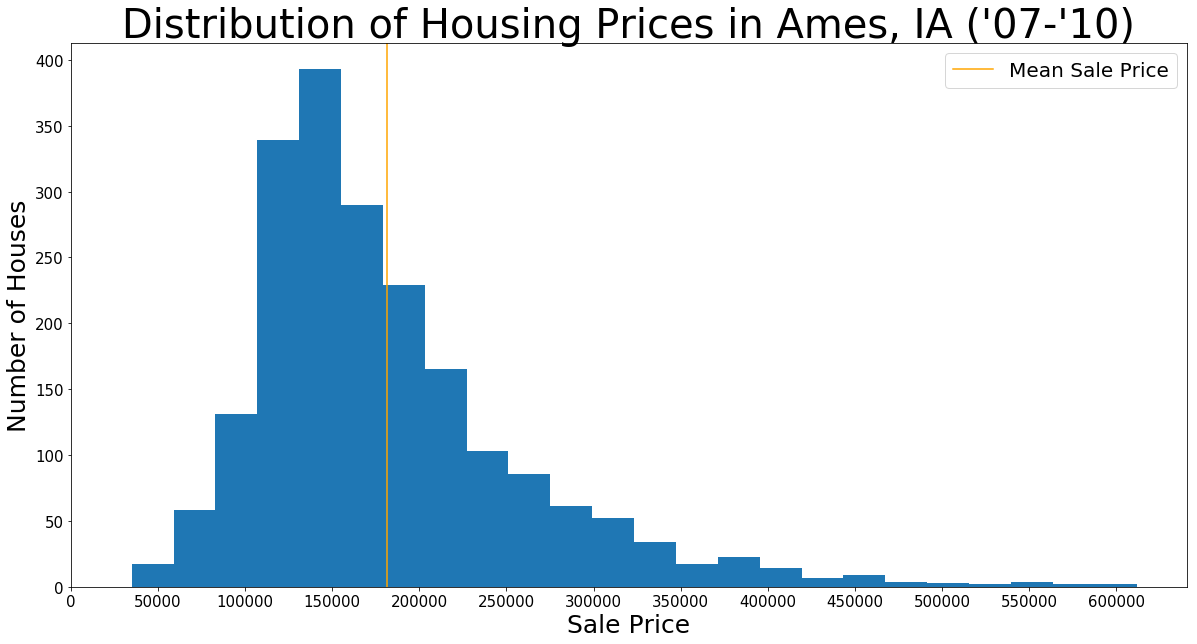

In [5]:
plt.figure(figsize=(20, 10))
plt.hist(df.SalePrice, bins=24)
plt.title("Distribution of Housing Prices in Ames, IA ('07-'10)", fontsize=40)
plt.xticks(ticks=range(0, 625000, 50000), fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Sale Price', fontsize=25)
plt.ylabel('Number of Houses', fontsize=25)
plt.axvline(df.SalePrice.mean(), color='orange', label='Mean Sale Price')
plt.legend(fontsize=20);
# plt.savefig('../viz_exports/distribution.png');

The `SalePrice` values are right-skewed, so our model is likely to underpredict when it's incorrect. If we're using this model for the purposes of tax assessment, that means we'll be leaving money on the table if we follow the model blindly. This isn't a fatal flaw, but if the model goes into production it will need to be considered with that caveat.

My next step is to use histograms to examine the distribution of the other numerical features for any possible insights.

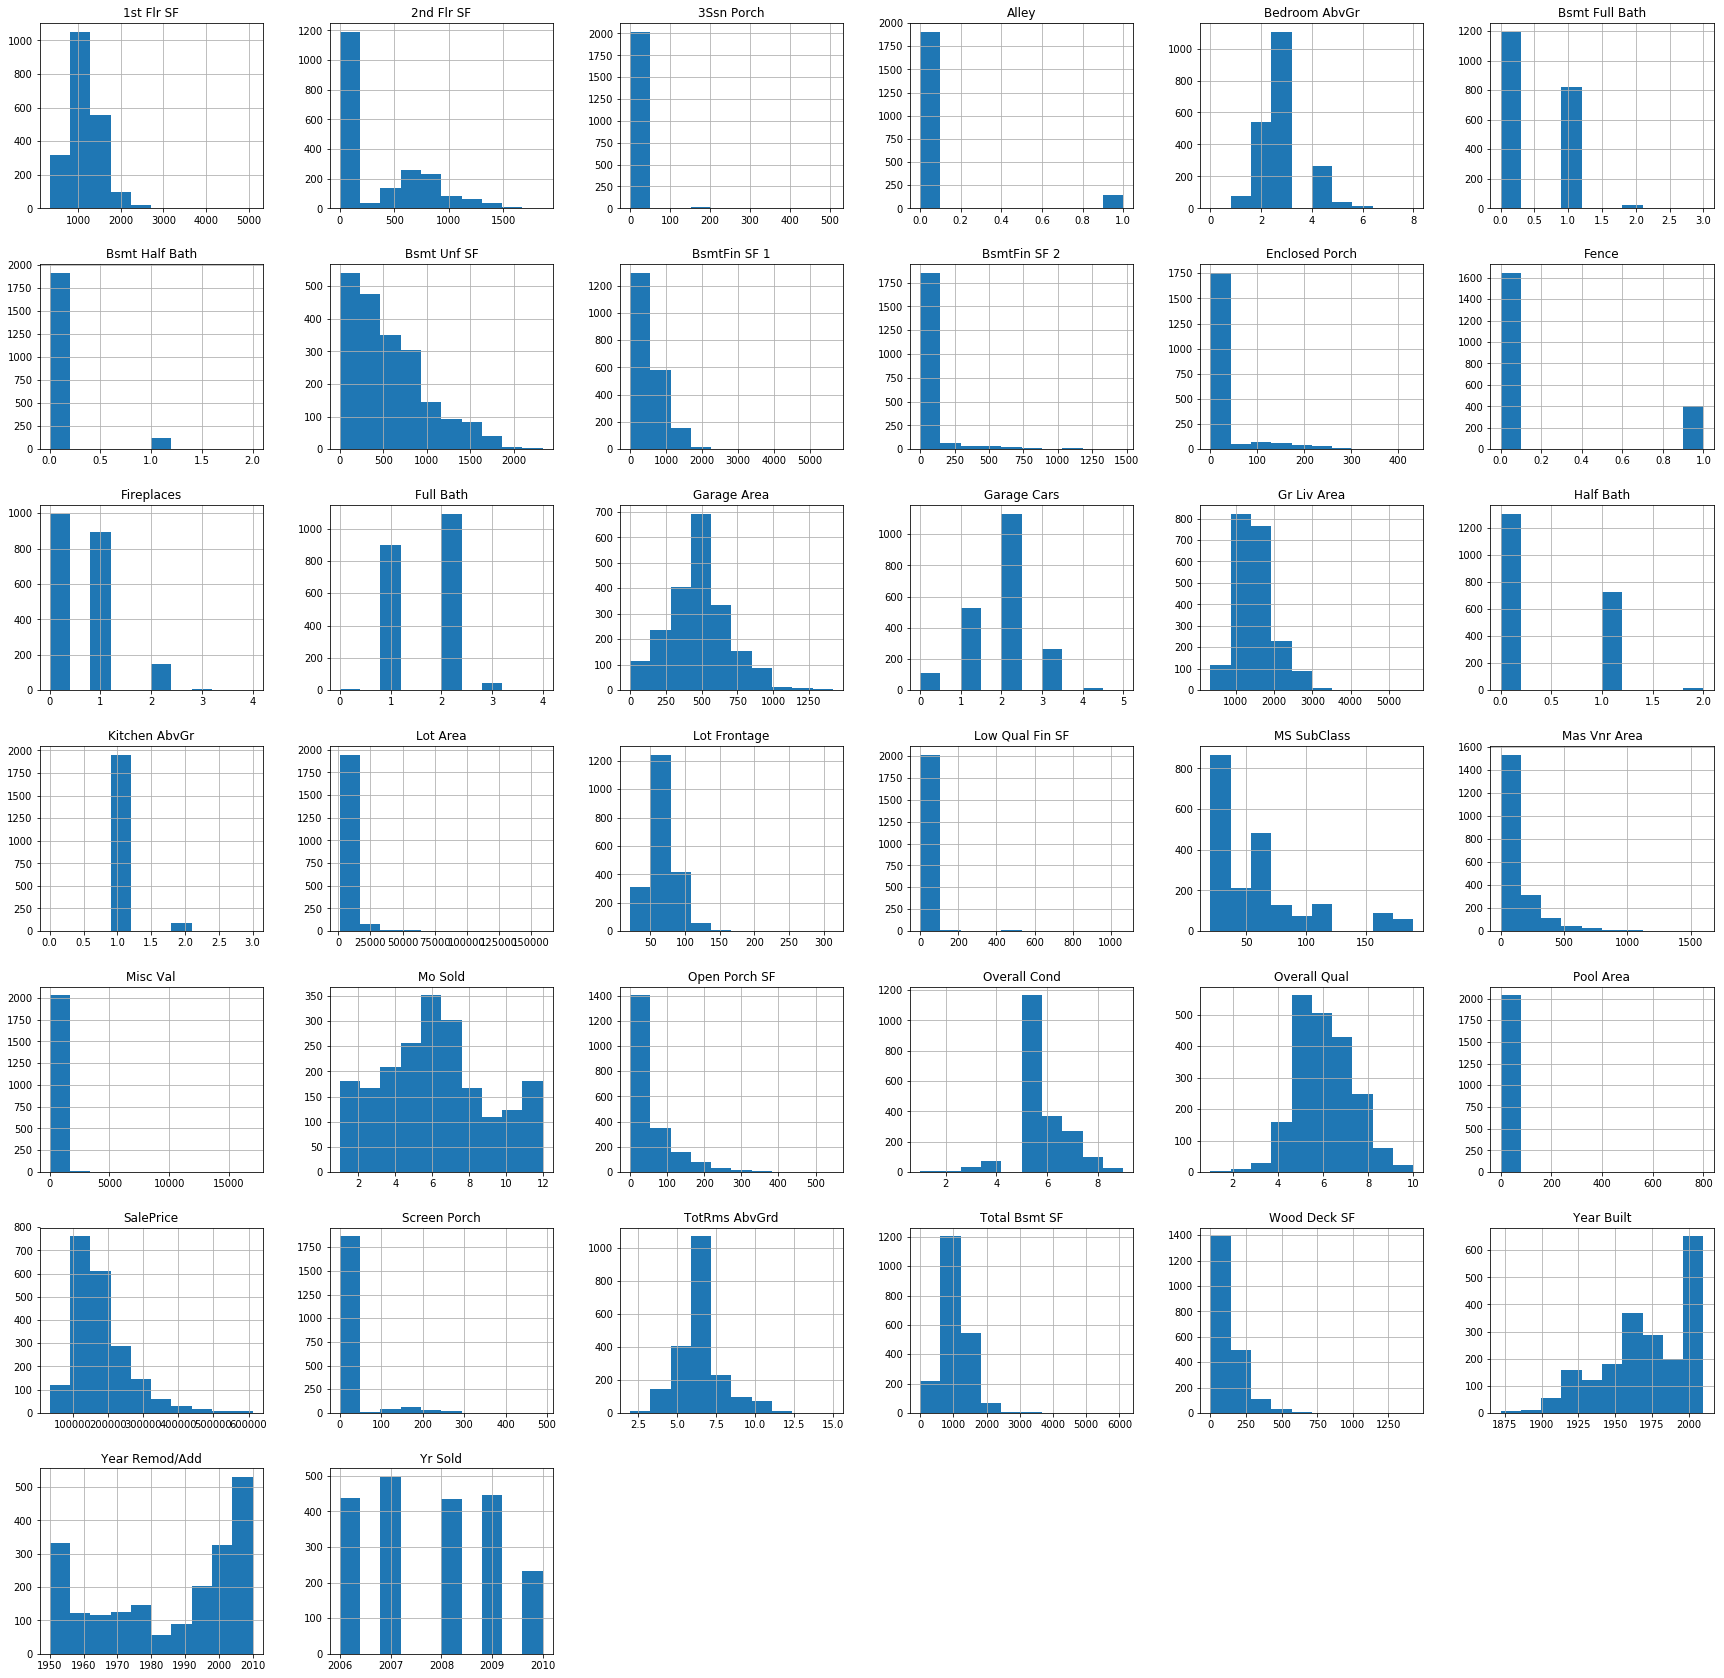

In [6]:
df.hist(figsize=(30, 30));

I want to reformat the features that are scored on a scale of 1-10. Binning them into five qualitative values should make those features more consistent predictors of price. I will write a function that performs this reformatting.

In [7]:
def scale_10_rewrite(column):
    for row in df.index:
        if df.loc[row, column] >= 9:
            df.loc[row, column] = str('Ex')
        elif df.loc[row, column] >= 7:
            df.loc[row, column] = str('Gd')
        elif df.loc[row, column] >= 4:
            df.loc[row, column] = str('Avg')
        elif df.loc[row, column] >= 1:
            df.loc[row, column] = str('Fa')
        else:
            df.loc[row, column] = str('Po')
    return

Now I'll pass the `Overall Qual` and `Overall Cond` features to that function and verify that it works properly.

In [8]:
scale_10_rewrite('Overall Qual')
scale_10_rewrite('Overall Cond')

df[df.columns[df.columns.str.contains('Overall')]].head()

,Overall Qual,Overall Cond
Id,,
109,Avg,Gd
544,Gd,Avg
153,Avg,Gd
318,Avg,Avg
255,Avg,Gd


In the histograms above, `Garage Area` and `Garage Cars` have very similar distributions and they deal with the same general feature, namely garage size. I'll 

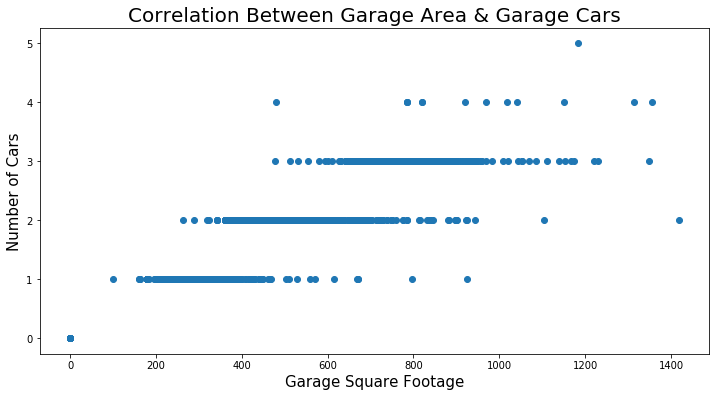

In [9]:
plt.figure(figsize=(12,6))
plt.scatter(x=df['Garage Area'], y=df['Garage Cars'])
plt.title(label='Correlation Between Garage Area & Garage Cars', fontsize=20)
plt.ylabel('Number of Cars', fontsize=15)
plt.xlabel('Garage Square Footage', fontsize=15);

`Garage Area` and `Garage Cars` are basically telling us the same thing and they appear to have a collinear relationship, so I will drop `Garage Area` from our dataset to avoid collinearity in those features.

In [10]:
df.drop(columns = 'Garage Area', inplace=True)

`Garage Qual` and `Garage Cond` likewise seem to overlap too much to keep both, so I'll drop `Garage Cond`.

In [11]:
df.drop(columns='Garage Cond', inplace=True)

Additionally, the information that is encoded in `Garage Finish` is likely already factored into `Garage Qual` so I'll drop `Garage Finish` and convert `Garage Qual` into a 4-bin category, with three quality options and a fourth for properties that have no garage.

In [12]:
df.drop(columns = 'Garage Finish', inplace = True)

df['Garage Qual'] = df['Garage Qual'].map({'Ex': 'Gd', 'Gd': 'Gd',
                                         'TA': 'TA',
                                         'Fa': 'Po', 'Po': 'Po',
                                          'NA': 'NA'})

`Pool Area`'s distribution in the charts above looks heavily one-sided so I want to take another look at that feature.

In [13]:
df['Pool Area'].describe()

count    2045.00000
mean        2.40489
std        37.83776
min         0.00000
25%         0.00000
50%         0.00000
75%         0.00000
max       800.00000
Name: Pool Area, dtype: float64

`Pool Area` is even more skewed than I thought, so I'd like to see if `Pool QC` would work better as a categorical feature.

In [14]:
df['Pool QC'].value_counts()

NA    2036
Gd       4
Fa       2
TA       2
Ex       1
Name: Pool QC, dtype: int64

Indeed, there are very few properties with pools in our dataset, so I will drop `Pool Area` and let `Pool QC` stand as the heavy influencer for those properties that do have a pool.

In [15]:
df.drop(columns = 'Pool Area', inplace=True)

`Heating` is another feature that seems to be double-represented with `Heating QC`. I'll drop `Heating` since `Heating QC` is probably more informative, and I'll convert `Heating QC` from a 5-step quality scale to a 3-step scale.

In [16]:
df.drop(columns = 'Heating', inplace=True)

df['Heating QC'] = df['Heating QC'].map({'Ex': 'Gd', 'Gd': 'Gd',
                                         'TA': 'TA',
                                         'Fa': 'Po', 'Po': 'Po'})

I'll convert `Central Air` to a numeric binary column that corresponds to its current Y/N value.

In [17]:
df['Central Air'] = df['Central Air'].map({'Y': int(1), 'N': int(0)})

I want to visualize the correlation of our remaining numeric values with `SalePrice`.

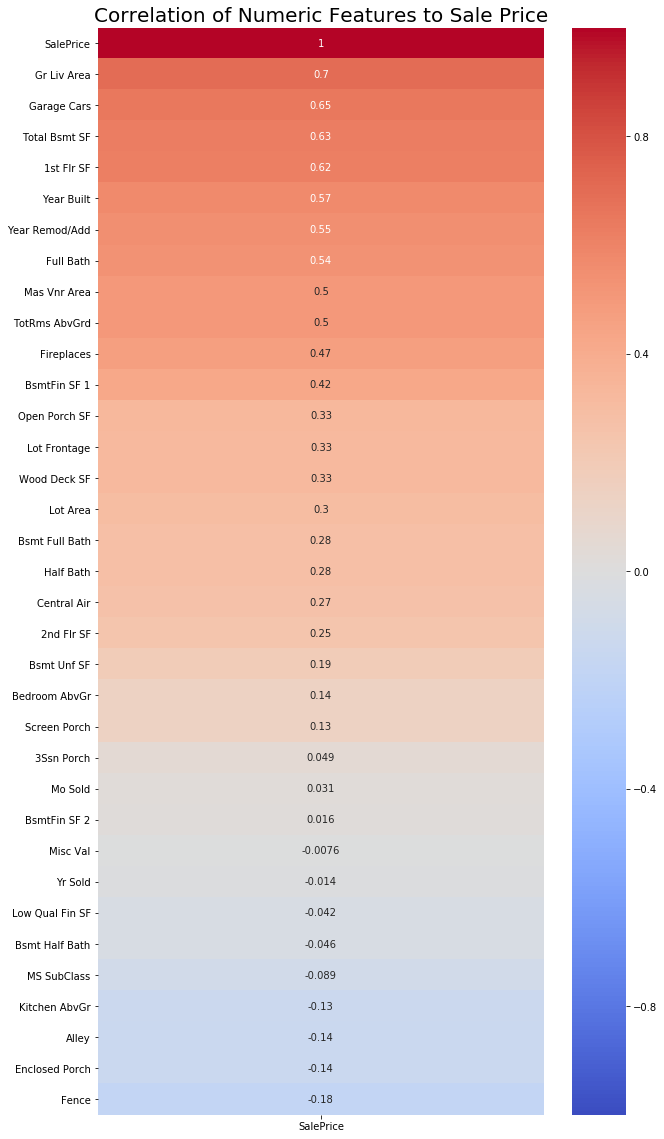

In [18]:
plt.figure(figsize=(10,20))
sns.heatmap(df.corr()[['SalePrice']].sort_values('SalePrice', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(label='Correlation of Numeric Features to Sale Price', fontsize=20);

`Mo Sold`, `BsmtFin SF 2`, `Misc Val`, and `Yr Sold` all have almost no correlation with `SalePrice`, so I'll drop those features. 

In [19]:
df.drop(columns=['Mo Sold', 'BsmtFin SF 2', 'Misc Val', 'Yr Sold'], inplace=True)

### One-Hot Encoding

Before I go any further I will dummy out the qualitative features in the dataset. I won't be able to model on non-numeric features so this command will expand each qualitative feature into a group of binary features for each possible value in the original column.

In [20]:
df_dummies = pd.get_dummies(df)

Now that the values in the dataframe are entirely numeric, I can begin modeling on it.

## Modeling

### Train-Test-Split & Scale

Now that I'm done preparing the dataframe, I will first split it into X and y. The y values will be the values from `SalePrice`. These represent our targets. And X will contain all of the non-price features.

In [21]:
X=df_dummies.drop(columns='SalePrice')
y=df_dummies.SalePrice

Now I will split both X and y into a training set and a test set. This allows me to model on only the training portion of the data and evaluate the model's performance on data that it has not seen.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Lastly I will instantiate the StandardScaler and use it to scale the X training data. This will normalize the values in X so that features like square footage (which could have values in the thousands) won't have disproportionate weight in the model compared to features like `Garage Cars` that will max out in the single digits, or the dummy features which can only be 0 or 1. That same transformation will then be applied to the X testing data.

In [23]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

/Users/BK/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/BK/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/BK/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


### Comparing Models

Before pursuing a production model I will run cross-validation tests on the dataset with linear regression, lasso CV, and ridge CV models. The cross-validation tests will apply a version of each model to five different splits of the dataset and average the results. The type of model that returns the best score will be the most promising for my purposes.

First I will instantiate all three models.

In [24]:
lr = LinearRegression()
lasso = LassoCV(cv=5)
ridge = RidgeCV(cv=5)

Next I will calculate and print the cross-validation scores of the three models.

In [25]:
print(f'Linear Regression: {cross_val_score(lr, X_train_sc, y_train, cv=5).mean()}')
print(f'Lasso: {cross_val_score(lasso, X_train_sc, y_train, cv=5).mean()}')
print(f'Ridge: {cross_val_score(ridge, X_train_sc, y_train, cv=5).mean()}')

Linear Regression: -2.160694881481364e+25
Lasso: 0.8395495803686046
Ridge: 0.8171708133078379


Linear regression is returning a terrible score, most likely because there are still so many features being used in the model. Ridge and lasso are returning much better scores because they are reducing or eliminating the effect of collinear features, respectively. Since the lasso model is slightly better I will proceed with it by fitting a lasso model to the training set and finding its r2 score on the training set.

In [26]:
lasso.fit(X_train_sc, y_train)

lasso.score(X_train_sc, y_train)

0.931331264873064

Since r2 scores range from 0 to 1, a score of .931 is great. This means that over 93% of the variance in `SalePrice` can be explained by the model. That's a great training score, but now I need to see how the model performs with the test split to make sure the model wasn't just overfit to the training data.

In [27]:
lasso.score(X_test_sc, y_test)

0.9157212392199375

This score means that the model holds up well against the testing data, which it hadn't seen yet. Since the model is performing well so far, I'll use it to make some predictions so I can check its RMSE (root-mean-square error).

In [28]:
preds = lasso.predict(X_test_sc)

(mean_squared_error(y_test, preds)) ** .5

22958.77918696125

This is a pretty good RMSE score. It means that on average the model will predict within $22,958.78 of the actual target. Now I'll plot those predictions against the actual prices for those properties so the strength of the model can be judged visually.

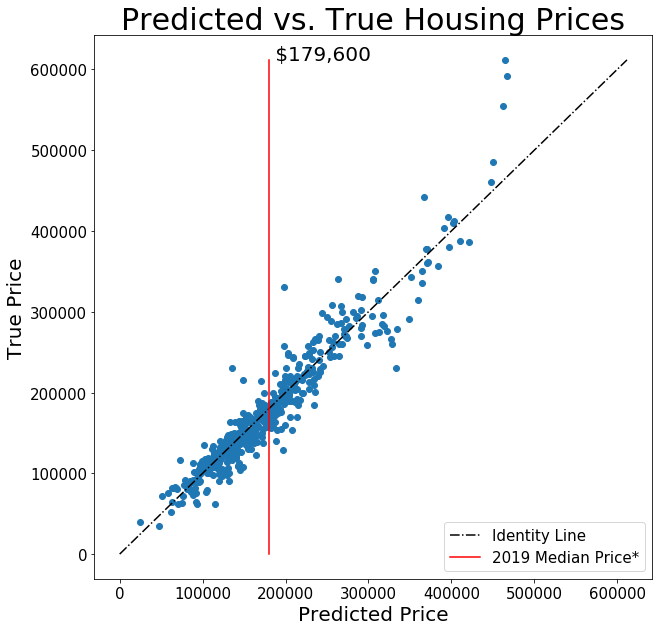

In [29]:
plt.figure(figsize=(10,10))
plt.scatter(preds, y_test, label=None)
plt.plot((0, y_test.max()), (0,y_test.max()), 'k-.', label='Identity Line')
plt.plot((179600, 179600), (0,y_test.max()), 'r-', label='2019 Median Price*')
plt.title('Predicted vs. True Housing Prices', fontsize=30)
plt.xlabel('Predicted Price', fontsize=20)
plt.ylabel('True Price', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.annotate(' $179,600', (179600,y_test.max()), fontsize=20)
plt.legend(fontsize=15, loc='lower right');
# plt.savefig('../viz_exports/pred_vs_true2.png');

Despite the starting strength of the model, I want to do just a little tuning on it in a new notebook. I'll pickle the model, scaler, and a list of the dummied column names to use in the new notebook, and I'll export the dummied CSV as well.

In [30]:
# with open('../assets/lasso_lin_reg.pkl', 'wb+') as f:
#     pickle.dump(lasso, f)
# with open('../assets/scaler.pkl', 'wb+') as f:
#     pickle.dump(ss, f)
# with open('../assets/columns.pkl', 'wb+') as f:
#     pickle.dump(list(df_dummies.columns), f)

# df_dummies.to_csv('../datasets/train_clean_dummies.csv')

All the data should be ready to go in Notebook #3.